Rendering smooth high-contrast 2x2 GIF...
Saved snapshot: ctc_sequence_1.png (frame 0)
Saved snapshot: ctc_sequence_1.png (frame 0)
Saved snapshot: ctc_sequence_2.png (frame 31)
Saved snapshot: ctc_sequence_3.png (frame 58)
Saved snapshot: ctc_sequence_4.png (frame 89)
Saved GIF: ctc_bullet_2x2_smooth2.gif


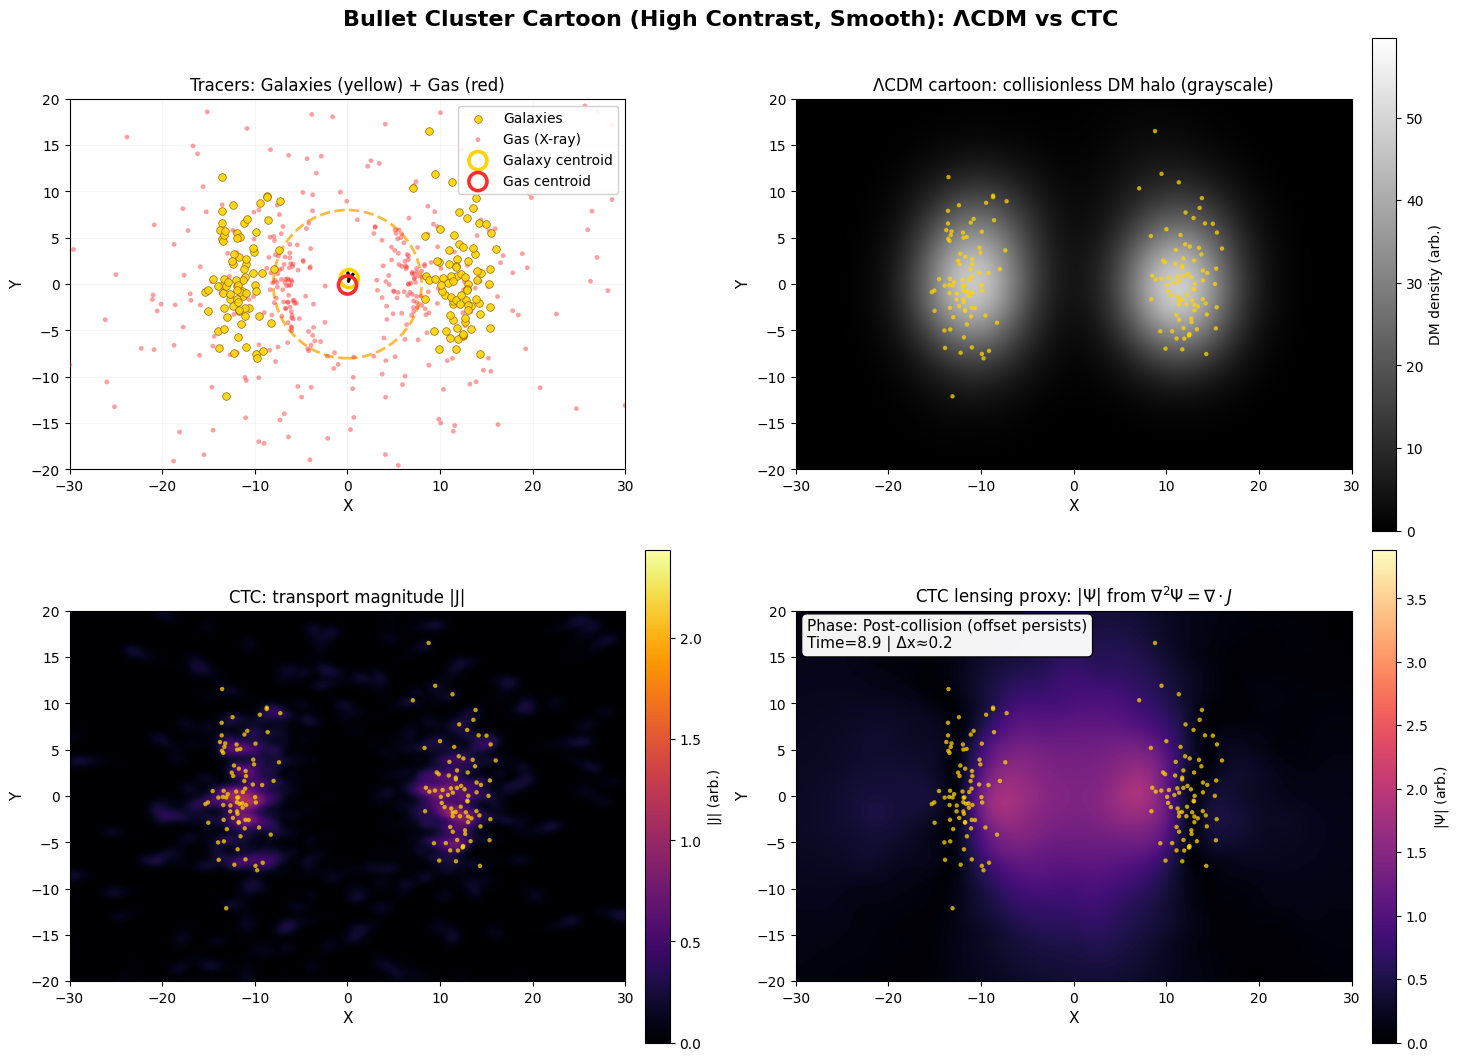

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.patches import Circle
from scipy.ndimage import gaussian_filter
import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

# ===================== USER SETTINGS =====================
N_FRAMES = 90
DT = 0.10

GIF_NAME = "ctc_bullet_2x2_smooth2.gif"
GIF_FPS  = 12
GIF_DPI  = 180

SAVE_SNAPSHOTS = True
SNAP_FRAMES = [0, int(0.35*N_FRAMES), int(0.65*N_FRAMES), N_FRAMES-1]

SHOW_GAL_OVERLAY_ON_FIELDS = True
SHOW_GAS_OVERLAY_ON_FIELDS = False

# Contrast + stability
PCTL_HI = 99.3
WARMUP_FRAMES = 10           # compute vmax during this window
FREEZE_CLIM = True           # freeze after warmup
EMA_VMAX_ALPHA = 0.20        # only used during warmup
FIELD_TEMPORAL_BETA = 0.25   # temporal smoothing of fields (0..1), higher = less smoothing
MIN_VMAX = 1e-9

# Gas thermal noise: OU process for smooth jitter
OU_RHO = 0.90                # closer to 1 -> smoother
OU_SIGMA = 0.10              # strength of thermal kicks (effective)

# ===================== DOMAIN =====================
XLIM = (-30, 30)
YLIM = (-20, 20)

GRID_SIZE = 120
COLLISION_R = 8.0

grid_x = np.linspace(XLIM[0], XLIM[1], GRID_SIZE)
grid_y = np.linspace(YLIM[0], YLIM[1], GRID_SIZE)
X, Y = np.meshgrid(grid_x, grid_y)

dx = grid_x[1] - grid_x[0]
dy = grid_y[1] - grid_y[0]
xmin, xmax = grid_x[0], grid_x[-1]
ymin, ymax = grid_y[0], grid_y[-1]

def in_bounds_mask(x, y):
    return (x >= XLIM[0]) & (x <= XLIM[1]) & (y >= YLIM[0]) & (y <= YLIM[1])

def phase_label(t):
    if t < 4.0:
        return "Approach"
    elif t < 8.0:
        return "Mid-collision (gas shocks/thermalizes)"
    return "Post-collision (offset persists)"

# ===================== PARTICLES =====================
n_galaxies = 160
n_gas = 400

# Cluster 1 (left -> right)
cluster1_x = np.random.normal(-15, 2, n_galaxies // 2)
cluster1_y = np.random.normal(0, 2, n_galaxies // 2)
cluster1_vx = np.ones(n_galaxies // 2) * 3.0
cluster1_vy = np.random.normal(0, 0.5, n_galaxies // 2)

gas1_x = np.random.normal(-15, 3, n_gas // 2)
gas1_y = np.random.normal(0, 3, n_gas // 2)
gas1_vx = np.ones(n_gas // 2) * 3.0
gas1_vy = np.random.normal(0, 0.8, n_gas // 2)

# Cluster 2 (right -> left)
cluster2_x = np.random.normal(15, 2, n_galaxies // 2)
cluster2_y = np.random.normal(0, 2, n_galaxies // 2)
cluster2_vx = np.ones(n_galaxies // 2) * -3.0
cluster2_vy = np.random.normal(0, 0.5, n_galaxies // 2)

gas2_x = np.random.normal(15, 3, n_gas // 2)
gas2_y = np.random.normal(0, 3, n_gas // 2)
gas2_vx = np.ones(n_gas // 2) * -3.0
gas2_vy = np.random.normal(0, 0.8, n_gas // 2)

galaxy_x = np.concatenate([cluster1_x, cluster2_x]).copy()
galaxy_y = np.concatenate([cluster1_y, cluster2_y]).copy()
galaxy_vx = np.concatenate([cluster1_vx, cluster2_vx]).copy()
galaxy_vy = np.concatenate([cluster1_vy, cluster2_vy]).copy()

gas_x = np.concatenate([gas1_x, gas2_x]).copy()
gas_y = np.concatenate([gas1_y, gas2_y]).copy()
gas_vx = np.concatenate([gas1_vx, gas2_vx]).copy()
gas_vy = np.concatenate([gas1_vy, gas2_vy]).copy()

# OU noise state for gas (persistent, smooth)
eta_x = np.zeros_like(gas_vx)
eta_y = np.zeros_like(gas_vy)

# ===================== FIELD BUILDERS =====================
def calculate_flux_and_div(px, py, vx, vy, smooth_flux=1.35, smooth_div=1.05):
    fx = np.zeros((GRID_SIZE, GRID_SIZE), dtype=float)
    fy = np.zeros((GRID_SIZE, GRID_SIZE), dtype=float)

    for x, y, ux, uy in zip(px, py, vx, vy):
        if (x < xmin) or (x > xmax) or (y < ymin) or (y > ymax):
            continue
        i = np.digitize(x, grid_x) - 1
        j = np.digitize(y, grid_y) - 1
        if i < 0 or i >= GRID_SIZE - 1 or j < 0 or j >= GRID_SIZE - 1:
            continue

        tx = (x - grid_x[i]) / (grid_x[i + 1] - grid_x[i] + 1e-12)
        ty = (y - grid_y[j]) / (grid_y[j + 1] - grid_y[j] + 1e-12)

        w00 = (1 - tx) * (1 - ty)
        w10 = tx * (1 - ty)
        w01 = (1 - tx) * ty
        w11 = tx * ty

        fx[j, i]         += ux * w00
        fx[j, i + 1]     += ux * w10
        fx[j + 1, i]     += ux * w01
        fx[j + 1, i + 1] += ux * w11

        fy[j, i]         += uy * w00
        fy[j, i + 1]     += uy * w10
        fy[j + 1, i]     += uy * w01
        fy[j + 1, i + 1] += uy * w11

    fx = gaussian_filter(fx, sigma=smooth_flux)
    fy = gaussian_filter(fy, sigma=smooth_flux)

    divJ = np.gradient(fx, dx, axis=1) + np.gradient(fy, dy, axis=0)
    divJ = gaussian_filter(divJ, sigma=smooth_div)

    Jmag = np.sqrt(fx**2 + fy**2)
    return divJ, Jmag

def _hann2d(ny, nx, edge_frac=0.12):
    wy = np.ones(ny); wx = np.ones(nx)
    ey = max(2, int(edge_frac * ny))
    ex = max(2, int(edge_frac * nx))
    y_ramp = 0.5 * (1 - np.cos(np.linspace(0, np.pi, ey)))
    x_ramp = 0.5 * (1 - np.cos(np.linspace(0, np.pi, ex)))
    wy[:ey] *= y_ramp
    wy[-ey:] *= y_ramp[::-1]
    wx[:ex] *= x_ramp
    wx[-ex:] *= x_ramp[::-1]
    return wy[:, None] * wx[None, :]

def psi_abs_from_div(divJ, pad=70, smooth_sigma=1.6, edge_frac=0.12):
    div0 = divJ - np.mean(divJ)
    div0 *= _hann2d(*div0.shape, edge_frac=edge_frac)

    divP = np.pad(div0, ((pad, pad), (pad, pad)), mode="constant", constant_values=0.0)
    Ny, Nx = divP.shape

    kx = np.fft.fftfreq(Nx, d=dx) * 2 * np.pi
    ky = np.fft.fftfreq(Ny, d=dy) * 2 * np.pi
    KX, KY = np.meshgrid(kx, ky)
    K2 = KX**2 + KY**2
    K2[0, 0] = 1.0

    divK = np.fft.fft2(divP)
    PsiK = -divK / K2
    PsiP = np.real(np.fft.ifft2(PsiK))

    Psi = PsiP[pad:pad+GRID_SIZE, pad:pad+GRID_SIZE]
    Psi = gaussian_filter(Psi, sigma=smooth_sigma)
    return np.abs(Psi)

def dm_cartoon_density(gx, gy, sigma=4.0):
    dm = np.zeros_like(X, dtype=float)
    inv2s2 = 1.0 / (2.0 * sigma * sigma)
    for x, y in zip(gx, gy):
        dm += np.exp(-((X - x) ** 2 + (Y - y) ** 2) * inv2s2)
    return gaussian_filter(dm, sigma=1.0)

def robust_vmax(field, p=PCTL_HI):
    v = np.percentile(field[np.isfinite(field)], p)
    return float(max(v, MIN_VMAX))

def ema(old, new, a=EMA_VMAX_ALPHA):
    return new if old is None else (1 - a) * old + a * new

# Temporal smoothing buffers
DM_prev = None
J_prev  = None
P_prev  = None

# Vmax trackers
vmax_dm = None
vmax_J  = None
vmax_P  = None

snap_map = {fr: i+1 for i, fr in enumerate(SNAP_FRAMES)}

# ===================== DYNAMICS =====================
def update_positions_gal(x, y, vx, vy):
    return x + vx*DT, y + vy*DT, vx, vy

def update_positions_gas(x, y, vx, vy):
    global eta_x, eta_y

    new_x = x + vx * DT
    new_y = y + vy * DT

    # drag
    vx *= 0.985
    vy *= 0.985

    # OU thermal noise (smooth in time)
    eta_x = OU_RHO * eta_x + np.sqrt(max(1e-12, 1 - OU_RHO**2)) * np.random.normal(0, 1, len(vx))
    eta_y = OU_RHO * eta_y + np.sqrt(max(1e-12, 1 - OU_RHO**2)) * np.random.normal(0, 1, len(vy))
    vx += OU_SIGMA * eta_x
    vy += OU_SIGMA * eta_y

    # collision region: slowdown + stronger heating (still smooth due to OU)
    r = np.sqrt(new_x**2 + new_y**2)
    mask = r < COLLISION_R
    if np.any(mask):
        vx[mask] *= 0.55
        vy[mask] *= 0.55

        # extra OU-like impulse inside collision zone
        vx[mask] += 0.18 * eta_x[mask]
        vy[mask] += 0.18 * eta_y[mask]

    return new_x, new_y, vx, vy

# ===================== INITIAL FIELDS =====================
div0, J0 = calculate_flux_and_div(
    np.concatenate([galaxy_x, gas_x]),
    np.concatenate([galaxy_y, gas_y]),
    np.concatenate([galaxy_vx, gas_vx]),
    np.concatenate([galaxy_vy, gas_vy]),
)
P0 = psi_abs_from_div(div0)
DM0 = dm_cartoon_density(galaxy_x, galaxy_y)

# seed temporal buffers
DM_prev = DM0.copy()
J_prev  = J0.copy()
P_prev  = P0.copy()

# seed vmax
vmax_dm = robust_vmax(DM0)
vmax_J  = robust_vmax(J0)
vmax_P  = robust_vmax(P0)

# ===================== FIGURE =====================
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14.5, 10.5), constrained_layout=True)
fig.suptitle("Bullet Cluster Cartoon in 2D : ΛCDM vs CTC",
             fontsize=16, fontweight="bold")

for ax in (ax1, ax2, ax3, ax4):
    ax.set_xlim(*XLIM); ax.set_ylim(*YLIM)
    ax.set_aspect("equal")
    ax.set_xlabel("X", fontsize=11)
    ax.set_ylabel("Y", fontsize=11)

# Panel 1
ax1.set_title("Tracers: Galaxies (yellow) + Gas (red)", fontsize=12)
ax1.grid(True, alpha=0.12)

mg = in_bounds_mask(galaxy_x, galaxy_y)
ms = in_bounds_mask(gas_x, gas_y)

scat_g = ax1.scatter(galaxy_x[mg], galaxy_y[mg], s=30, alpha=0.90,
                     c="#FFD400", edgecolor="#8A5A00", linewidth=0.5, label="Galaxies", zorder=5)
scat_s = ax1.scatter(gas_x[ms], gas_y[ms], s=12, alpha=0.45,
                     c="#FF2D2D", edgecolor="none", label="Gas (X-ray)", zorder=4)

ax1.add_patch(Circle((0, 0), COLLISION_R, fill=False, color="orange",
                     linestyle="--", alpha=0.75, linewidth=2.0, zorder=3))

gC = (float(np.mean(galaxy_x)), float(np.mean(galaxy_y)))
sC = (float(np.mean(gas_x)), float(np.mean(gas_y)))

cent_g = ax1.scatter([gC[0]], [gC[1]], s=170, facecolors="none",
                     edgecolors="#FFD400", linewidths=2.6, zorder=7, label="Galaxy centroid")
cent_s = ax1.scatter([sC[0]], [sC[1]], s=170, facecolors="none",
                     edgecolors="#FF2D2D", linewidths=2.6, zorder=7, label="Gas centroid")
arrow = ax1.annotate("", xy=sC, xytext=gC,
                     arrowprops=dict(arrowstyle="->", lw=2.4, alpha=0.95, color="black"))
ax1.legend(loc="upper right", framealpha=0.90)

# Panel 2: DM
ax2.set_title("ΛCDM cartoon: collisionless DM halo (grayscale)", fontsize=12)
im_dm = ax2.imshow(DM0, extent=[*XLIM, *YLIM], origin="lower",
                   cmap="gray", vmin=0.0, vmax=vmax_dm, interpolation="bilinear")
fig.colorbar(im_dm, ax=ax2, fraction=0.046, pad=0.02).set_label("DM density (arb.)", fontsize=10)

# Panel 3: |J|
ax3.set_title("CTC: transport magnitude |J|", fontsize=12)
im_J = ax3.imshow(J0, extent=[*XLIM, *YLIM], origin="lower",
                  cmap="inferno", vmin=0.0, vmax=vmax_J, interpolation="bilinear")
fig.colorbar(im_J, ax=ax3, fraction=0.046, pad=0.02).set_label("|J| (arb.)", fontsize=10)

# Panel 4: |Psi|
ax4.set_title(r"CTC lensing proxy: $|\Psi|$ from $\nabla^2\Psi=\nabla\cdot J$", fontsize=12)
im_P = ax4.imshow(P0, extent=[*XLIM, *YLIM], origin="lower",
                  cmap="magma", vmin=0.0, vmax=vmax_P, interpolation="bilinear")
fig.colorbar(im_P, ax=ax4, fraction=0.046, pad=0.02).set_label(r"$|\Psi|$ (arb.)", fontsize=10)

# Animated overlays (never frozen)
ov_g2 = ov_g3 = ov_g4 = None
ov_s2 = ov_s3 = ov_s4 = None

if SHOW_GAL_OVERLAY_ON_FIELDS:
    ov_g2 = ax2.scatter(galaxy_x[mg], galaxy_y[mg], s=10, c="#FFD400", alpha=0.75, edgecolors="none", zorder=10)
    ov_g3 = ax3.scatter(galaxy_x[mg], galaxy_y[mg], s=10, c="#FFD400", alpha=0.75, edgecolors="none", zorder=10)
    ov_g4 = ax4.scatter(galaxy_x[mg], galaxy_y[mg], s=10, c="#FFD400", alpha=0.75, edgecolors="none", zorder=10)

if SHOW_GAS_OVERLAY_ON_FIELDS:
    ov_s2 = ax2.scatter(gas_x[ms], gas_y[ms], s=6, c="#FF2D2D", alpha=0.35, edgecolors="none", zorder=9)
    ov_s3 = ax3.scatter(gas_x[ms], gas_y[ms], s=6, c="#FF2D2D", alpha=0.35, edgecolors="none", zorder=9)
    ov_s4 = ax4.scatter(gas_x[ms], gas_y[ms], s=6, c="#FF2D2D", alpha=0.35, edgecolors="none", zorder=9)

phase_box = ax4.text(0.02, 0.98, "Phase: Approach\nTime=0.0 | Δx≈0.0",
                     transform=ax4.transAxes, va="top", ha="left", fontsize=11,
                     bbox=dict(boxstyle="round,pad=0.35", facecolor="white",
                               alpha=0.96, edgecolor="black", linewidth=1.0))

# ===================== SNAPSHOTS =====================
def save_snapshot(frame_idx):
    outname = f"ctc_sequence_{snap_map[frame_idx]}.png"
    fig.savefig(outname, dpi=220, facecolor="white")
    print(f"Saved snapshot: {outname} (frame {frame_idx})")

# ===================== ANIMATION STEP =====================
def step(frame):
    global galaxy_x, galaxy_y, galaxy_vx, galaxy_vy
    global gas_x, gas_y, gas_vx, gas_vy
    global DM_prev, J_prev, P_prev
    global vmax_dm, vmax_J, vmax_P

    # Move particles (smooth gas noise)
    galaxy_x, galaxy_y, galaxy_vx, galaxy_vy = update_positions_gal(galaxy_x, galaxy_y, galaxy_vx, galaxy_vy)
    gas_x, gas_y, gas_vx, gas_vy = update_positions_gas(gas_x, gas_y, gas_vx, gas_vy)

    mg = in_bounds_mask(galaxy_x, galaxy_y)
    ms = in_bounds_mask(gas_x, gas_y)

    # Update tracer scatters
    scat_g.set_offsets(np.column_stack([galaxy_x[mg], galaxy_y[mg]]))
    scat_s.set_offsets(np.column_stack([gas_x[ms], gas_y[ms]]))

    # Centroids + arrow
    gC = (float(np.mean(galaxy_x)), float(np.mean(galaxy_y)))
    sC = (float(np.mean(gas_x)), float(np.mean(gas_y)))
    cent_g.set_offsets([gC])
    cent_s.set_offsets([sC])
    arrow.xy = sC
    arrow.set_position(gC)

    # Compute raw fields
    DM_raw = dm_cartoon_density(galaxy_x, galaxy_y)
    divJ, J_raw = calculate_flux_and_div(
        np.concatenate([galaxy_x, gas_x]),
        np.concatenate([galaxy_y, gas_y]),
        np.concatenate([galaxy_vx, gas_vx]),
        np.concatenate([galaxy_vy, gas_vy]),
    )
    P_raw = psi_abs_from_div(divJ)

    # Temporal smoothing (kills speckle/shake)
    DM = (1 - FIELD_TEMPORAL_BETA) * DM_prev + FIELD_TEMPORAL_BETA * DM_raw
    Jm = (1 - FIELD_TEMPORAL_BETA) * J_prev  + FIELD_TEMPORAL_BETA * J_raw
    P  = (1 - FIELD_TEMPORAL_BETA) * P_prev  + FIELD_TEMPORAL_BETA * P_raw

    DM_prev, J_prev, P_prev = DM, Jm, P

    # Update clims (warmup then freeze)
    if (not FREEZE_CLIM) or (frame < WARMUP_FRAMES):
        vmax_dm = ema(vmax_dm, robust_vmax(DM))
        vmax_J  = ema(vmax_J,  robust_vmax(Jm))
        vmax_P  = ema(vmax_P,  robust_vmax(P))

    # Update images
    im_dm.set_data(DM); im_dm.set_clim(0.0, vmax_dm)
    im_J.set_data(Jm);  im_J.set_clim(0.0, vmax_J)
    im_P.set_data(P);   im_P.set_clim(0.0, vmax_P)

    # Update animated overlays (never frozen)
    if SHOW_GAL_OVERLAY_ON_FIELDS:
        coords_g = np.column_stack([galaxy_x[mg], galaxy_y[mg]])
        ov_g2.set_offsets(coords_g); ov_g3.set_offsets(coords_g); ov_g4.set_offsets(coords_g)
    if SHOW_GAS_OVERLAY_ON_FIELDS:
        coords_s = np.column_stack([gas_x[ms], gas_y[ms]])
        ov_s2.set_offsets(coords_s); ov_s3.set_offsets(coords_s); ov_s4.set_offsets(coords_s)

    # Text
    t = frame * DT
    dx_sep = abs(gC[0] - sC[0])
    phase_box.set_text(f"Phase: {phase_label(t)}\nTime={t:.1f} | Δx≈{dx_sep:.1f}")

    if SAVE_SNAPSHOTS and frame in snap_map:
        save_snapshot(frame)

    artists = [scat_g, scat_s, cent_g, cent_s, arrow, im_dm, im_J, im_P, phase_box]
    if SHOW_GAL_OVERLAY_ON_FIELDS:
        artists += [ov_g2, ov_g3, ov_g4]
    if SHOW_GAS_OVERLAY_ON_FIELDS:
        artists += [ov_s2, ov_s3, ov_s4]
    return tuple(artists)

# ===================== SAVE GIF =====================
print("Rendering smooth high-contrast 2x2 GIF...")
anim = FuncAnimation(fig, step, frames=N_FRAMES, interval=100, blit=False)
anim.save(GIF_NAME, writer=PillowWriter(fps=GIF_FPS), dpi=GIF_DPI,
          savefig_kwargs={"facecolor": "white"})
print(f"Saved GIF: {GIF_NAME}")
plt.show()


